In [79]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from sklearn.compose import ColumnTransformer
import graphviz
import re
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [80]:
# Загрузка данных
file_path = './adult 3 (1).csv'
df = pd.read_csv(file_path)
df = df.replace('?', pd.NA).dropna()
print(f"Размер датасета после удаления пропусков: {df.shape}\n")

Размер датасета после удаления пропусков: (45222, 15)



### Провести дескриптивный анализ

In [81]:
numeric_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df_analysis = df.copy()
df_analysis['income_num'] = (df_analysis['income'] == '>50K').astype(int)

for col in numeric_cols:
    print(f"\n--- {col.upper()} ---")
    desc = df_analysis[col].describe()
    print(desc)
    mode_value = df_analysis[col].mode()
    if not mode_value.empty:
        print(f"Мода: {mode_value.iloc[0]}")
    else:
        print(f"Мода не найдена.")
    # Асимметрия и эксцесс
    sk = skew(df_analysis[col])
    kt = kurtosis(df_analysis[col])
    print(f"Асимметрия (skewness): {sk:.3f} - {'правосторонняя' if sk > 0.5 else 'левосторонняя' if sk < -0.5 else 'умеренная'}")
    print(f"Эксцесс (kurtosis):   {kt:.3f} - {'островершинное' if kt > 3 else 'плосковершинное' if kt < 0 else 'нормальное'}")


--- AGE ---
count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64
Мода: 36
Асимметрия (skewness): 0.533 - правосторонняя
Эксцесс (kurtosis):   -0.156 - плосковершинное

--- EDUCATIONAL-NUM ---
count    45222.000000
mean        10.118460
std          2.552881
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: educational-num, dtype: float64
Мода: 9
Асимметрия (skewness): -0.311 - умеренная
Эксцесс (kurtosis):   0.635 - нормальное

--- CAPITAL-GAIN ---
count    45222.000000
mean      1101.430344
std       7506.430084
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64
Мода: 0
Асимметрия (skewness): 11.789 - правосторонняя
Эксцесс (kurtosis):   150.135 - островершинное

--- CAPITAL-LOSS 

### Построение гистограмм

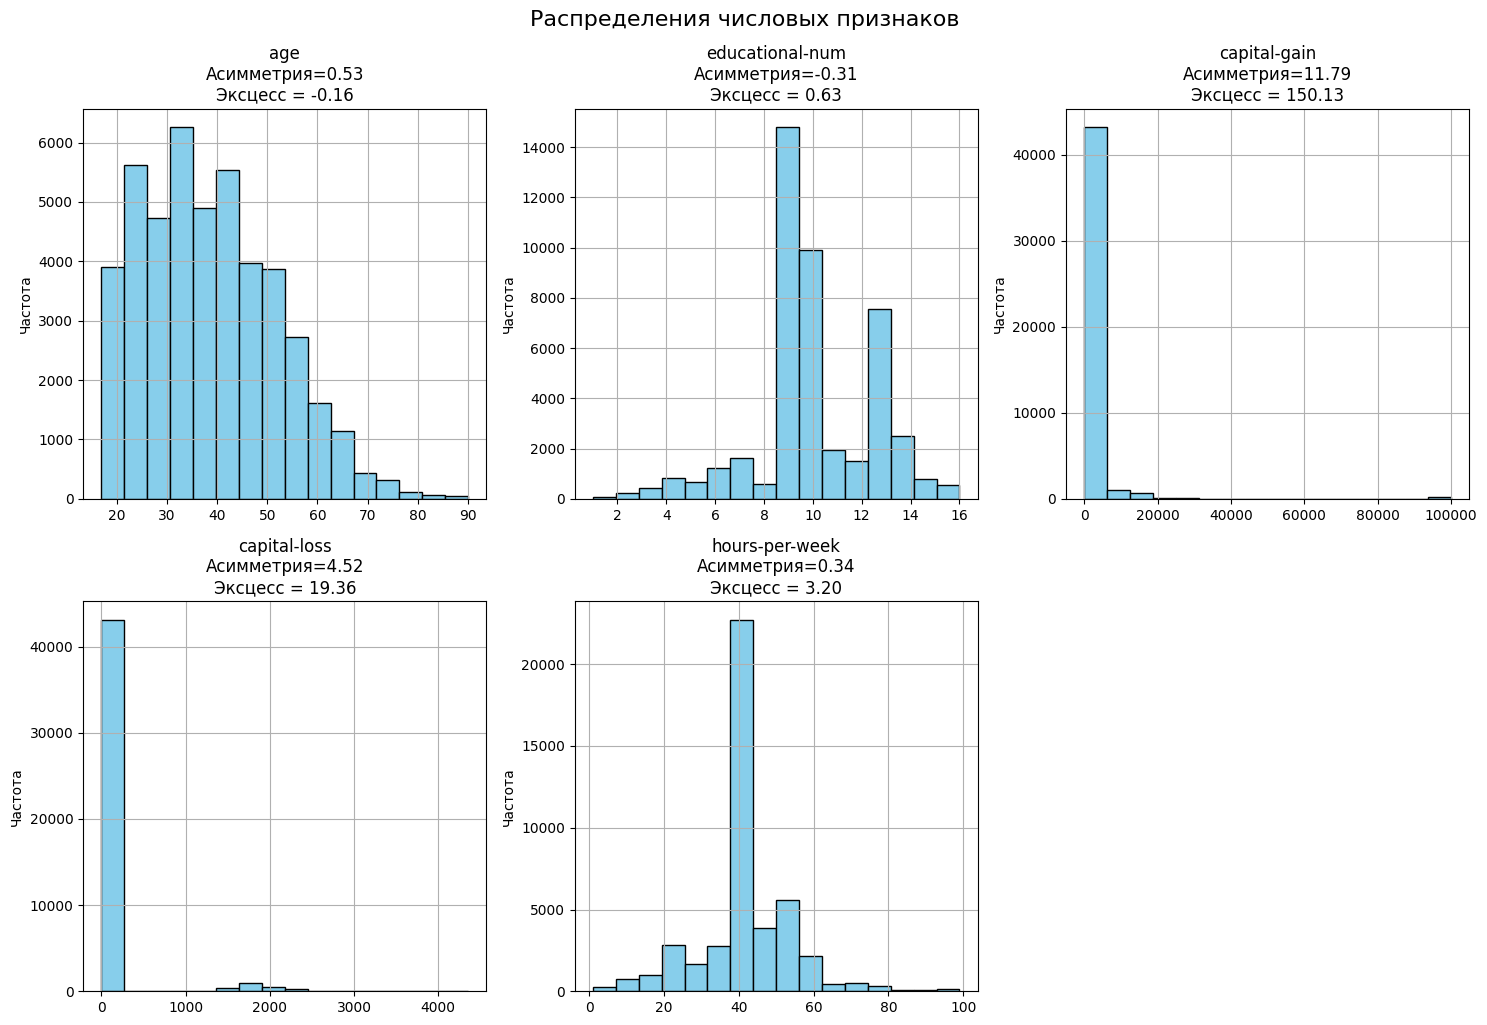

In [89]:
count_intervals = int(1 + math.log2(df_analysis.shape[0]))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df_analysis[col].hist(bins=count_intervals, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col}\nАсимметрия={skew(df_analysis[col]):.2f}\nЭксцесс = {kurtosis(df_analysis[col]):.2f}')
    axes[i].set_ylabel('Частота')
axes[-1].axis('off')
plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

### Анализ категориальных данных (распределение объектов по классам и для с доходом >50K в каждой категории)

In [87]:
categorical_cols = ['income','workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'gender', 'native-country']

df['income_num'] = (df['income'] == '>50K').astype(int)

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    
    # 1. Распределение категорий (частота в %)
    dist = df[col].value_counts(normalize=True) * 100
    print("Распределение категорий (% от общего числа):")
    for cat, pct in dist.items():
        print(f"  {cat}: {pct:.2f}%")
    
    # 2. Доля >50K в каждой категории
    income_by_cat = df.groupby(col)['income_num'].mean().sort_values(ascending=False)
    print("\nДоля с доходом >50K в каждой категории:")
    for cat, prop in income_by_cat.items():
        print(f"  {cat}: {prop:.2%}")
    
    print("-" * 50)


--- INCOME ---
Распределение категорий (% от общего числа):
  <=50K: 75.22%
  >50K: 24.78%

Доля с доходом >50K в каждой категории:
  >50K: 100.00%
  <=50K: 0.00%
--------------------------------------------------

--- WORKCLASS ---
Распределение категорий (% от общего числа):
  Private: 73.65%
  Self-emp-not-inc: 8.39%
  Local-gov: 6.86%
  State-gov: 4.30%
  Self-emp-inc: 3.64%
  Federal-gov: 3.11%
  Without-pay: 0.05%

Доля с доходом >50K в каждой категории:
  Self-emp-inc: 55.41%
  Federal-gov: 39.05%
  Local-gov: 29.52%
  Self-emp-not-inc: 27.90%
  State-gov: 26.72%
  Private: 21.77%
  Without-pay: 9.52%
--------------------------------------------------

--- EDUCATION ---
Распределение категорий (% от общего числа):
  HS-grad: 32.69%
  Some-college: 21.89%
  Bachelors: 16.74%
  Masters: 5.56%
  Assoc-voc: 4.33%
  11th: 3.58%
  Assoc-acdm: 3.33%
  10th: 2.70%
  7th-8th: 1.82%
  Prof-school: 1.74%
  9th: 1.49%
  12th: 1.28%
  Doctorate: 1.20%
  5th-6th: 0.99%
  1st-4th: 0.49%
  Pre

### Аргументировать выбор методов решения задачи классификации по результатам описания датасета.
Анализ датасета Adult показал, что задача прогнозирования годового дохода (≤50K / >50K) обладает рядом характерных особенностей, определяющих выбор методов машинного обучения. Во-первых, распределение целевой переменной демонстрирует умеренный дисбаланс классов: доля объектов с доходом ≤50K составляет 75.2%, что требует применения методов, устойчивых к несбалансированности, либо использования взвешивания классов. Во-вторых, признаковое пространство включает как числовые (возраст, количество рабочих часов, уровень образования, капитальный доход и убыток), так и категориальные переменные (профессия, социальная роль, тип занятости), причём последние содержат значимую предсказательную информацию — например, доля лиц с доходом >50K варьируется от 1.4% (дошкольное образование) до 75.4% (профессиональная школа).

Кроме того, числовые признаки существенно отклоняются от нормального распределения: наблюдается асимметрия и высокие заначения эксцесс, а такие переменные, как capital-gain и capital-loss, являются сильно разреженными (более 90% нулевых значений). Это исключает применение методов, предполагающих нормальность распределений или линейные зависимости.

С учётом перечисленных особенностей для решения задачи были выбраны два метода: дерево решений и полносвязная нейронная сеть. Дерево решений было принято в качестве основного метода, поскольку оно эффективно работает с табличными данными смешанного типа, не требует нормализации признаков, устойчиво к выбросам и нарушению нормальности, а также обеспечивает высокую интерпретируемость — что особенно важно при анализе социально-экономических факторов, влияющих на доход. Нейронная сеть использована в качестве альтернативного подхода для оценки потенциала нелинейного моделирования сложных взаимодействий между признаками. Однако её применение требует тщательной предобработки: One-Hot кодирования категориальных переменных и масштабирования числовых признаков. Учитывая умеренный объём выборки (~45 тыс. наблюдений) и отсутствие глубоких иерархических структур в данных, ожидается, что дерево решений продемонстрирует сопоставимую или лучшую обобщающую способность при значительно более высокой интерпретируемости.

### Провести отбор наиболее информативных признаков. 

In [84]:
for col in numeric_cols:
    avg_by_income = df.groupby('income_num')[col].mean()
    print(f"\nСреднее значение '{col}' по классам:")
    print(f"  <=50K (0): {avg_by_income[0]:.2f}")
    print(f"  >50K  (1): {avg_by_income[1]:.2f}")
    print(f"  Разница: {avg_by_income[1] - avg_by_income[0]:+.2f}")

print("\nКорреляция числовых признаков с доходом (>50K):")
corr_with_target = df_analysis[numeric_cols + ['income_num']].corr()['income_num'].abs().sort_values(ascending=False)
print(corr_with_target.drop('income_num'))

# 4.2 Категориальные: максимальная доля >50K и размах
print("\nМаксимальная доля >50K в категориях:")
cat_strength = {}
for col in categorical_cols:
    max_prop = df_analysis.groupby(col)['income_num'].mean().max()
    min_prop = df_analysis.groupby(col)['income_num'].mean().min()
    range_prop = max_prop - min_prop
    cat_strength[col] = {'max': max_prop, 'range': range_prop}
    print(f"{col:18s}: макс. {max_prop:.2%} | размах {range_prop:.2%}")

# Сортируем по размаху (насколько категория разделяет классы)
cat_rank = sorted(cat_strength.items(), key=lambda x: x[1]['range'], reverse=True)
print("\nРанжирование категориальных признаков по размаху доли >50K:")
for col, metrics in cat_rank[:]:
    print(f"{col}: размах = {metrics['range']:.2%}")


Среднее значение 'age' по классам:
  <=50K (0): 36.75
  >50K  (1): 44.01
  Разница: +7.26

Среднее значение 'educational-num' по классам:
  <=50K (0): 9.63
  >50K  (1): 11.60
  Разница: +1.97

Среднее значение 'capital-gain' по классам:
  <=50K (0): 149.02
  >50K  (1): 3991.79
  Разница: +3842.77

Среднее значение 'capital-loss' по классам:
  <=50K (0): 54.03
  >50K  (1): 193.49
  Разница: +139.45

Среднее значение 'hours-per-week' по классам:
  <=50K (0): 39.37
  >50K  (1): 45.69
  Разница: +6.32

Корреляция числовых признаков с доходом (>50K):
educational-num    0.332800
age                0.237040
hours-per-week     0.227199
capital-gain       0.221034
capital-loss       0.148687
Name: income_num, dtype: float64

Максимальная доля >50K в категориях:
workclass         : макс. 55.41% | размах 45.88%
education         : макс. 75.41% | размах 74.03%
marital-status    : макс. 45.42% | размах 40.62%
occupation        : макс. 47.91% | размах 46.62%
relationship      : макс. 48.59% | разма

Наиболее информативными признаны признаки, демонстрирующие наибольшую способность разделять классы по доходу:

Среди числовых — educational-num (корреляция 0.33), age и hours-per-week (оба ~0.23), а также capital-gain и capital-loss, несмотря на разреженность.

Среди категориальных — education (размах 74%), relationship (47%), occupation (46.6%) и workclass (45.9%).

Признаки race, gender и native-country исключены: первые два — из-за слабой предсказательной силы, последний — из-за статистической ненадёжности (крайний дисбаланс категорий).
marital-status исключён как дублирующий более информативный признак relationship.